In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
class BSplineActivation(nn.Module):
    def __init__(self, num_ctrl_pts=10):
        super(BSplineActivation, self).__init__()
        self.num_ctrl_pts = num_ctrl_pts
        self.ctrl_pts = nn.Parameter(torch.linspace(-1, 1, num_ctrl_pts))
        self.coeffs = nn.Parameter(torch.randn(num_ctrl_pts))

    def forward(self, x):
        x = x.clamp(-1, 1)
        idx = ((x + 1) / 2 * (self.num_ctrl_pts - 1)).long().clamp(0, self.num_ctrl_pts - 2)
        x0 = self.ctrl_pts[idx]
        x1 = self.ctrl_pts[idx + 1]
        y0 = self.coeffs[idx]
        y1 = self.coeffs[idx + 1]
        t = (x - x0) / (x1 - x0 + 1e-8)
        return (1 - t) * y0 + t * y1

In [ ]:
class SimpleKAN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=64, output_dim=10):
        super(SimpleKAN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.spline = BSplineActivation()
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.hidden(x)
        x = self.spline(x)
        x = self.output(x)
        return x

In [ ]:
def get_non_iid_partition(dataset, num_clients=5):
    labels = np.array(dataset.targets)
    indices = [[] for _ in range(num_clients)]
    for i in range(10):
        i_indices = np.where(labels == i)[0]
        np.random.shuffle(i_indices)
        for j in range(num_clients):
            if i % num_clients == j:
                indices[j].extend(i_indices[:len(i_indices)//2])
    client_loaders = []
    for i in range(num_clients):
        subset = Subset(dataset, indices[i])
        loader = DataLoader(subset, batch_size=32, shuffle=True)
        client_loaders.append(loader)
    return client_loaders

In [ ]:
def train_local(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += data.size(0)
    return total_loss / total, correct / total

In [ ]:
def federated_train(global_model, client_loaders, device, rounds=10):
    criterion = nn.CrossEntropyLoss()
    train_loss, train_acc = [], []

    for r in range(rounds):
        local_models = []
        local_losses, local_accs = [], []
        for loader in client_loaders:
            model = SimpleKAN().to(device)
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(model.parameters(), lr=0.01)
            loss, acc = train_local(model, loader, criterion, optimizer, device)
            local_models.append(model.state_dict())
            local_losses.append(loss)
            local_accs.append(acc)

        # FedAvg
        new_state = global_model.state_dict()
        for key in new_state.keys():
            new_state[key] = torch.stack([m[key].float() for m in local_models], 0).mean(0)
        global_model.load_state_dict(new_state)

        avg_loss = np.mean(local_losses)
        avg_acc = np.mean(local_accs)
        train_loss.append(avg_loss)
        train_acc.append(avg_acc)
        print(f"Round {r+1}: Loss={avg_loss:.4f}, Accuracy={avg_acc*100:.2f}%")

    return train_loss, train_acc

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
    return correct / total

In [ ]:
def test_with_image(model, test_loader, device):
    import random
    model.eval()
    images, labels = next(iter(test_loader))
    idx = random.randint(0, len(images)-1)
    img = images[idx].to(device)
    label = labels[idx].item()

    with torch.no_grad():
        output = model(img.unsqueeze(0))
        pred = output.argmax(dim=1).item()

    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.title(f"Predicted: {pred}, True: {label}")
    plt.axis('off')
    plt.show()

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]



Starting Federated Training...

Round 1: Loss=0.3073, Accuracy=93.07%
Round 2: Loss=0.4844, Accuracy=84.66%
Round 3: Loss=0.5948, Accuracy=73.54%
Round 4: Loss=0.5718, Accuracy=74.62%
Round 5: Loss=0.3944, Accuracy=83.97%
Round 6: Loss=0.7920, Accuracy=89.62%
Round 7: Loss=0.5804, Accuracy=82.58%
Round 8: Loss=0.4876, Accuracy=86.92%
Round 9: Loss=0.4241, Accuracy=88.94%
Round 10: Loss=0.3757, Accuracy=90.08%
Round 11: Loss=0.3365, Accuracy=91.02%
Round 12: Loss=0.3049, Accuracy=91.71%
Round 13: Loss=0.2795, Accuracy=92.15%
Round 14: Loss=0.2594, Accuracy=92.69%
Round 15: Loss=0.2434, Accuracy=92.90%
Round 16: Loss=0.2296, Accuracy=93.20%
Round 17: Loss=0.2177, Accuracy=93.65%
Round 18: Loss=0.2083, Accuracy=93.77%
Round 19: Loss=0.2005, Accuracy=93.90%
Round 20: Loss=0.1933, Accuracy=94.08%
Round 21: Loss=0.1876, Accuracy=94.25%
Round 22: Loss=0.1818, Accuracy=94.45%
Round 23: Loss=0.1768, Accuracy=94.62%
Round 24: Loss=0.1723, Accuracy=94.59%
Round 25: Loss=0.1686, Accuracy=94.76%
R

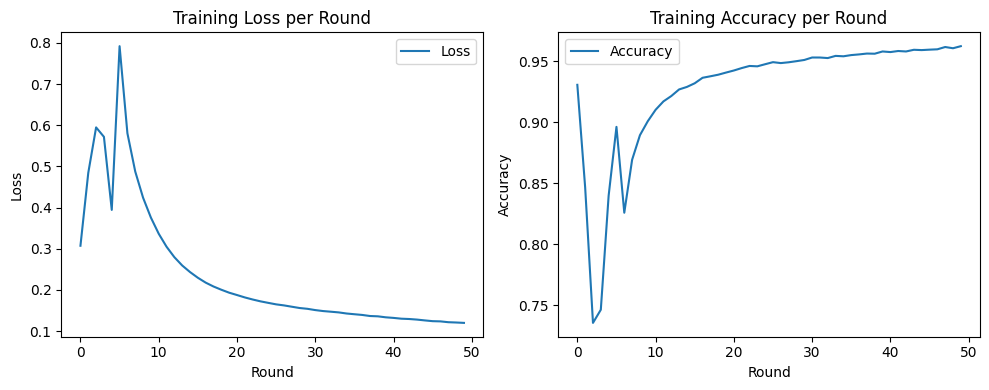

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

client_loaders = get_non_iid_partition(train_data, num_clients=5)
global_model = SimpleKAN().to(device)

print("\nStarting Federated Training...\n")
losses, accs = federated_train(global_model, client_loaders, device, rounds=50)

print("\nEvaluating on Test Data...")
test_acc = evaluate(global_model, test_loader, device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title("Training Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accs, label='Accuracy')
plt.title("Training Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

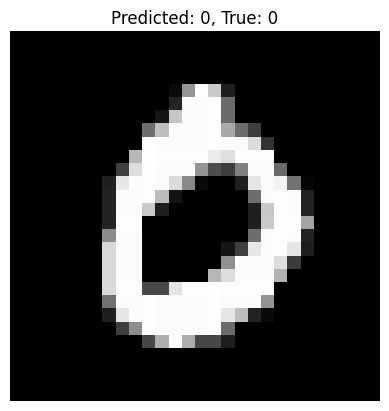

In [ ]:
test_with_image(global_model, test_loader, device)